# FastDetect

### Utils.py

In [1]:
import plotly.graph_objects as go
import os
from scipy.optimize import minimize
import math
from math import ceil, floor
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

USE_GPU = os.getenv("USE_GPU", "0") == "1"

if USE_GPU:
    try:
        import cupy as xp
        import cupyx.scipy.fft as xfft
        on_gpu = True

        asnumpy = xp.asnumpy    # CuPy → NumPy
        asarray = xp.asarray    # Python/NumPy → CuPy
    except ImportError:
        # fallback if cupy not installed
        import numpy as xp
        import scipy.fft as xfft
        on_gpu = False

        asnumpy = lambda a: a
        asarray = xp.asarray
else:
    import numpy as xp
    import scipy.fft as xfft
    on_gpu = False

    asnumpy = lambda a: a
    asarray = xp.asarray

# -------- light helpers (backend-agnostic) --------
def wrap(x):
    return (x + xp.pi) % (2 * xp.pi) - xp.pi


def to_device(x):
    """Move/convert Python or NumPy data to the active backend array (CuPy on GPU, NumPy on CPU)."""
    return asarray(x)

def to_host(x):
    """Ensure a NumPy array on host memory (identity on CPU)."""
    return asnumpy(x)

def to_scalar(x):
    """Return a Python scalar if x is 0-d array/array-like; otherwise return x unchanged."""
    # Works for both NumPy and CuPy
    try:
        if getattr(x, "shape", None) == ():
            return x.item()
    except Exception:
        pass
    return x

def sqlist(lst):
    return xp.array([to_scalar(item) for item in lst])

def myfft(chirp_data, n, plan):
    if USE_GPU:
        return xfft.fftshift(xfft.fft(chirp_data.astype(xp.complex64), n=n, plan=plan))
    else:
        return xfft.fftshift(xfft.fft(chirp_data.astype(xp.complex64), n=n))


def optimize_1dfreq_fast(sig2, tsymbr, freq1, margin):
    def obj1(freq, xdata, ydata):
        return to_scalar(-xp.abs(ydata.dot(xp.exp(xdata * -1j * 2 * xp.pi * freq.item()))))
    result = minimize(obj1, to_scalar(freq1), args=(tsymbr, sig2), bounds=[(freq1 - margin, freq1 + margin)]) #!!!
    return result.x[0], - result.fun / xp.sum(xp.abs(sig2))


def around(x):
    """Round to nearest integer (works for Python num or 0-d array)."""
    return round(float(to_scalar(x)))

def optimize_1dfreq(sig2, tsymbr, freq, margin):
    def obj1(xdata, ydata, freq):
        return xp.abs(ydata.dot(xp.exp(-1j * 2 * xp.pi * freq * xdata)))

    margin = 500
    val = obj1(tsymbr, sig2, freq)
    for i in range(10):
        xvals = xp.linspace(freq - margin, freq + margin, 1001)
        yvals = [obj1(tsymbr, sig2, f) for f in xvals]
        yvals = sqlist(yvals)
        freq = xvals[xp.argmax(yvals)]
        valnew = xp.max(yvals)
        if valnew < val * (1 - 1e-7):
            pltfig1(xvals, yvals, addvline=(freq,), title=f"Optimize_1dfreq {i=} {val=} {valnew=}").show()
        assert valnew >= val * (1 - 1e-7), f"{val=} {valnew=} {i=} {val-valnew=}"
        if abs(valnew - val) < 1e-7: margin /= 4
        val = valnew
    return freq, val / xp.sum(xp.abs(sig2))

def pltfig(datas, title = None, yaxisrange = None, modes = None, marker = None, addvline = None, addhline = None, line_dash = None, fig = None, line=None):
    """
    Plot a figure with the given data and parameters.

    Parameters:
    datas : list of tuples
        Each tuple contains two lists or array-like elements, the data for the x and y axes.
        If only y data is provided, x data will be generated using xp.arange.
    title : str, optional
        The title of the plot (default is None).
    yaxisrange : tuple, optional
        The range for the y-axis as a tuple (min, max) (default is None).
    mode : str, optional
        The mode of the plot (e.g., 'line', 'scatter') (default is None).
    marker : str, optional
        The marker style for the plot (default is None).
    addvline : float, optional
        The x-coordinate for a vertical line (default is None).
    addhline : float, optional
        The y-coordinate for a horizontal line (default is None).
    line_dash : str, optional
        The dash style for the line (default is None).
    fig : matplotlib.figure.Figure, optional
        The figure object to plot on (default is None).
    line : matplotlib.lines.Line2D, optional
        The line object for the plot (default is None).

    Returns:
    None
    """
    if fig is None: fig = go.Figure(layout_title_text=title)
    elif title is not None: fig.update_layout(title_text=title)
    if not all(len(data) == 2 for data in datas): datas = [(xp.arange(len(data)), data) for data in datas]
    # if not(all(len(data) == 2 for data in datas) and all(type(to_device(data[0])) == xp.array and type(to_device(data[1])) == xp.array  for data in datas)):
    #     print(len(datas[0]))
    #     print(len(datas[1]))
    #     print(type(datas[0][0]))
    #     print(type(datas[0][1]))
    #     print(type(datas[1][0]))
    #     print(type(datas[1][1]))
    #     print(datas[0][0].dtype)
    #     print(datas[0][1].dtype)
    #     print(datas[1][0].dtype)
    #     print(datas[1][1].dtype)
    assert all(len(data) == 2 for data in datas) 
    assert all(isinstance(to_device(data[0]), xp.ndarray) and isinstance(to_device(data[1]), xp.ndarray) for data in datas)
    if modes is None:
        modes = ['lines' for _ in datas]
    elif isinstance(modes, str):
        modes = [modes for _ in datas]
    for idx, ((xdata, ydata), mode) in enumerate(zip(datas, modes)):
        if line == None and idx == 1: line = dict(dash='dash')
        fig.add_trace(go.Scatter(x=to_host(xdata), y=to_host(ydata), mode=mode, marker=marker, line=line))
        assert len(to_host(xdata)) == len(to_host(ydata))
    pltfig_hind(addhline, addvline, line_dash, fig, yaxisrange)
    return fig



def pltfig1(xdata, ydata, title = None, yaxisrange = None, mode = None, marker = None, addvline = None, addhline = None, line_dash = None, fig = None, line=None):
    """
    Plot a figure with the given data and parameters.

    Parameters:
    xdata : list or array-like or None
        The data for the x-axis.
        If is None, and only y data is provided, x data will be generated using xp.arange.
    ydata : list or array-like
        The data for the y-axis.
    title : str, optional
        The title of the plot (default is None).
    yaxisrange : tuple, optional
        The range for the y-axis as a tuple (min, max) (default is None).
    mode : str, optional
        The mode of the plot (e.g., 'line', 'scatter') (default is None).
    marker : str, optional
        The marker style for the plot (default is None).
    addvline : float, optional
        The x-coordinate for a vertical line (default is None).
    addhline : float, optional
        The y-coordinate for a horizontal line (default is None).
    line_dash : str, optional
        The dash style for the line (default is None).
    fig : matplotlib.figure.Figure, optional
        The figure object to plot on (default is None).
    line : matplotlib.lines.Line2D, optional
        The line object for the plot (default is None).

    Returns:
    None
    """
    if xdata is None: xdata = xp.arange(len(ydata))
    if fig is None: fig = go.Figure(layout_title_text=title)
    elif title is not None: fig.update_layout(title_text=title)
    if mode is None: mode = 'lines'
    fig.add_trace(go.Scatter(x=to_host(xdata), y=to_host(ydata), mode=mode, marker=marker, line=line))
    assert len(to_host(xdata)) == len(to_host(ydata))
    pltfig_hind(addhline, addvline, line_dash, fig, yaxisrange)
    return fig

def pltfig_hind(addhline, addvline, line_dash_in, fig, yaxisrange):
    if yaxisrange: fig.update_layout(yaxis=dict(range=yaxisrange), )
    if addvline is not None:
        if line_dash_in is None:
            line_dash = ['dash' for _ in range(len(addvline))]
            line_dash[0] = 'dot'
        elif isinstance(line_dash_in, str):
            line_dash = [line_dash_in for _ in range(len(addvline))]
        else: line_dash = line_dash_in
        for x, ldash in zip(addvline, line_dash): fig.add_vline(x=to_scalar(x), line_dash=ldash)
    if addhline is not None:
        if line_dash_in is None:
            line_dash = ['dash' for _ in range(len(addhline))]
            line_dash[0] = 'dot'
        elif isinstance(line_dash_in, str):
            line_dash = [line_dash_in for _ in range(len(addhline))]
        else: line_dash = line_dash_in
        for y, ldash in zip(addhline, line_dash): fig.add_hline(y=to_scalar(y), line_dash=ldash)


### Config.py

In [2]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--sf', type=int, default=10, help="Set the value of sf")
# args = parser.parse_args(args=[])

class Config:
    sf = 12
    bw = 406250
    sig_freq = 2.41e9
    preamble_len = 240
    payload_len = 70
    guess_f = -40000
    fs = 1e6
    skip_preambles = 8
    code_len = 2

    sfdpos = preamble_len + code_len
    sfdend = sfdpos + 2
    total_len = sfdend + payload_len

    cfo_range = bw // 4
    n_classes = 2 ** sf
    tsig = 2 ** sf / bw * fs  # in samples
    nsamp = around(n_classes * fs / bw)
    nsampf = (n_classes * fs / bw)

    tstandard = xp.linspace(0, nsamp / fs, nsamp + 1)[:-1]
    decode_matrix_a = xp.zeros((n_classes, nsamp), dtype=xp.complex64)
    decode_matrix_b = xp.zeros((n_classes, nsamp), dtype=xp.complex64)

    betai = bw / ((2 ** sf) / bw)
    # wflag = True
    # for code in range(n_classes):
    #     if (code-1)%4!=0 and sf>=11 and wflag:
    #         wflag = False
    #         continue
    #     nsamples = around(nsamp / n_classes * (n_classes - code))
    #     f01 = bw * (-0.5 + code / n_classes)
    #     refchirpc1 = xp.exp(-1j * 2 * xp.pi * (f01 * tstandard + 0.5 * betai * tstandard * tstandard))
    #     f02 = bw * (-1.5 + code / n_classes)
    #     refchirpc2 = xp.exp(-1j * 2 * xp.pi * (f02 * tstandard + 0.5 * betai * tstandard * tstandard))
    #     decode_matrix_a[code, :nsamples] = refchirpc1[:nsamples]
    #     if code > 0: decode_matrix_b[code, nsamples:] = refchirpc2[nsamples:]

    detect_range_pkts = 1000 # !!! TODO
    fft_n = int(fs)
    if USE_GPU:
        plan = xfft.get_fft_plan(xp.zeros(fft_n, dtype=xp.complex64))
        plan2 = xfft.get_fft_plan(xp.zeros(nsamp, dtype=xp.complex64))
    else:
        plan = None
        plan2 = None

### Reader.py

In [3]:

class SlidingComplex64Reader: # TODO reader slow unbuffered
    dtype = xp.complex64
    itemsize = 8  # complex64

    def __init__(self, file_path):
        """
        Initializes the reader for a complex64 binary file.

        Args:
            file_path (str): The path to the binary file.
        """
        self.file_path = file_path

    def get(self, start, length):
        """
        Reads a chunk of data from the file.

        Args:
            start (int): The starting index (in terms of complex64 elements).
            length (int): The number of complex64 elements to read.

        Returns:
            xp.ndarray: An array containing the requested data.
        """
        byte_start = start * self.itemsize
        byte_length = length * self.itemsize

        try:
            with open(self.file_path, 'rb') as f:
                f.seek(byte_start)
                data_bytes = f.read(byte_length)

            if len(data_bytes) != byte_length:
                raise IOError(f"Read fewer bytes than expected. Expected {byte_length}, got {len(data_bytes)}")

            # Convert the bytes to a NumPy/CuPy array
            # Note: The .frombuffer method is efficient as it creates a view of the bytes.
            # We then copy it to the appropriate device (CPU or GPU) if necessary.
            data_array = xp.frombuffer(data_bytes, dtype=self.dtype)
            return data_array

        except FileNotFoundError:
            print(f"Error: The file '{self.file_path}' was not found.")
            return None
        except Exception as e:
            print(f"An error occurred: {e}")
            return None

### Main: Start Running

In [4]:
fstart = -41023.388364708379
tstart =  4240090.873306715
file_path = "data/test_1226"

file_size = os.path.getsize(file_path)
complex64_size = xp.dtype(xp.complex64).itemsize
assert complex64_size == 8
print(f"{file_path=} Size in Number of symbols: {file_size // complex64_size // Config.nsamp}")

reader = SlidingComplex64Reader(file_path)

file_path='data/test_1226' Size in Number of symbols: 1430


### Fitcoef: 

- Polynomial fit unwrapped phase of each symbol, generating 240 quadratic coefs 
    - Does not smooth the coef results
    - Fix beta, only change coeflist[:, 1] and coeflist[:, 2] via residue frequency and phase
- Compute phase difference between neighboring symbols 
    - Difference between two coefs at the tjump (time estimations from input)
    - Wrap into 2pi
    - Evaluate time difference that cause this (Use BW from input guessf, dt = dphase / estBW, estBW = Bw * (1 + estF / sigF))
    - Linear fit the time differences
    - Return new observations of tjump as a corrected coeft (len=2)


In [5]:
def fitcoef2(coeff: xp.array, coeft: xp.array, reader: SlidingComplex64Reader):
    betai = Config.bw / ((2 ** Config.sf) / Config.bw) * xp.pi # frequency slope to phase 2d slope, *pi
    coeflist = []

    for pidx in range(0, Config.preamble_len):
        
        # compute coef2d_est2: polynomial curve fitting unwrapped phase of symbol pidx
        # time: tstart to tend
        # frequency at tstart: - estbw * 0.5 + estf
        estf = xp.polyval(coeff, pidx)
        estbw = Config.bw * (1 + estf / Config.sig_freq)
        beta1 = betai * (1 + 2 * estf / Config.sig_freq)
        tstart = xp.polyval(coeft, pidx)
        tend = xp.polyval(coeft, pidx + 1)
        beta2 = 2 * xp.pi * (- estbw * 0.5 + estf) - tstart * 2 * beta1
        coef2d_est2 = xp.array([to_scalar(beta1), to_scalar(beta2), 0])

        # align 3rd parameter of coef2d_est2 to observed phase at tstart
        nsymbr_start = math.ceil(tstart * Config.fs + Config.nsamp / 8)
        nsymbr_end = math.ceil(tend * Config.fs - Config.nsamp / 8)
        nsymbr = xp.arange(math.ceil(tstart * Config.fs + Config.nsamp / 8), math.ceil(tend * Config.fs - Config.nsamp / 8))
        tsymbr = nsymbr / Config.fs

        sig0 = reader.get(nsymbr_start, nsymbr_end - nsymbr_start)
        sig1 = sig0 * xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))
        data0 = myfft(sig1, n=Config.fft_n, plan=Config.plan)
        freq1 = xp.fft.fftshift(xp.fft.fftfreq(Config.fft_n, d=1 / Config.fs))[xp.argmax(xp.abs(data0))]
        freq, valnew = optimize_1dfreq_fast(sig1, tsymbr, freq1, Config.fs / Config.fft_n * 5)
        # freqf, valnew = optimize_1dfreq(sig1, tsymbr, freq1, Config.fs / Config.fft_n * 5)
        # print(f"Initial freq offset: {freq1}, after FFT fit: {freq}, after precise fit: {freqf}, diff: {freqf - freq}")

        # adjust coef2d_est2[1] according to freq difference
        coef2d_est2[1] = 2 * xp.pi * (- estbw * 0.5 + estf + freq) - tstart * 2 * beta1
        sig2 = sig0 * xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))
        # freq, valnew = optimize_1dfreq(sig2, tsymbr, freq1, Config.fs / Config.fft_n * 5)
        # print(f"{freq=} should be zero {valnew=}")
        coef2d_est2[2] += xp.angle(sig0.dot(xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))))
        # print(f"{xp.angle(sig0.dot(xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))))} should be zero")
        coeflist.append(coef2d_est2)
    return xp.array(coeflist)



In [6]:
def fitcoef4(coeff: xp.array, coeft: xp.array, reader: SlidingComplex64Reader):
    coeflist = fitcoef2(coeff, coeft, reader)
    
    # plot phase difference between consecutive symbols
    phasedifflist = xp.zeros((Config.preamble_len - 1,), dtype=xp.float32)
    for pidx in range(Config.preamble_len - 1):
        tjump = xp.polyval(coeft, pidx + 1)
        phasediff = wrap(xp.polyval(coeflist[pidx + 1], tjump) - xp.polyval(coeflist[pidx], tjump))
        phasedifflist[pidx] = phasediff
    phasedifflist_unwrap = xp.unwrap(xp.array(phasedifflist))
    # pltfig1(range(Config.preamble_len - 1), phasedifflist_unwrap, title="plot phase difference between consecutive symbols").show()

    # fit a line to phase difference to estimate cfo and time drift
    tdifflist = xp.zeros_like(phasedifflist_unwrap)
    for pidx in range(Config.preamble_len - 1):
        estbw = Config.bw * (1 + xp.polyval(coeff, pidx + 0.5) / Config.sig_freq)
        tdifflist[pidx] = phasedifflist_unwrap[pidx] / 2 / xp.pi / estbw # phasediff is caused by mismatched symbol change time, -> bw mismatch. phase = 2pi * bw * dt
    xrange = xp.arange(50, len(tdifflist)) # !!! ignore first 50 points
    tdiff_coef = xp.polyfit(xrange, tdifflist[xrange], 1)
    coeft_new = coeft.copy()
    coeft_new[-2:] += tdiff_coef
    print(f"{tdiff_coef=} {coeft=} {coeft_new=} cfo ppm from time: {1 - coeft_new[0] / Config.nsampf * Config.fs} cfo: {(1 - coeft_new[0] / Config.nsampf * Config.fs) * Config.sig_freq} unwrapped phasediff so t may shift by margin {1/Config.bw}")

    return coeft_new

In [7]:
tsymblen = 2 ** Config.sf / Config.bw * (1 - fstart / Config.sig_freq)

coeff = xp.array((-0.512392321665, -41023.388364708379))
coeft = xp.array((1.01716420e-13, 1.00826333e-02, 4.24009137e+00))

# coeff = xp.array((0, fstart))
# coeft = xp.array((tsymblen, to_scalar(tstart) / Config.fs))
coeft = fitcoef4(coeff, coeft, reader)
# coeft = fitcoef4(coeff, coeft, reader) # do this to check correctness of fitcoef4

tdiff_coef=array([ 1.0820595e-10, -2.1580801e-09]) coeft=array([1.01716420e-13, 1.00826333e-02, 4.24009137e+00]) coeft_new=array([1.01716420e-13, 1.00826334e-02, 4.24009137e+00]) cfo ppm from time: 0.9999999999899115 cfo: 2409999999.9756866 unwrapped phasediff so t may shift by margin 2.4615384615384615e-06


### get coeflist from renewed coeft, and Find intersections between each coef

### findintersections.py

In [8]:
import numpy as np # for np.roots

# Function to find crossing points where poly(x) = (2n +1)*pi
def find_crossings(coef_in, x_min, x_max):
    coef = coef_in.copy()
    # coef[2] %= (2 * xp.pi)
    # ymin ymax: suppose is increasing/decreasing in this section
    assert not x_min <= - coef[1] / 2 / coef[0] <= x_max

    ya = xp.polyval(coef, x_min)
    yb = xp.polyval(coef, x_max)
    y_lower = min(ya, yb)
    y_upper = max(ya, yb)

    # Compute the range of n values
    n_min = ceil((y_lower - xp.pi) / (2 * xp.pi))
    n_max = floor((y_upper - xp.pi) / (2 * xp.pi))

    nrange = xp.arange(int(n_min), int(n_max) + 1)
    nrangex = xp.arange(int(n_min), int(n_max) + 2)
    crossings = xp.empty_like(nrange, dtype=xp.float64)

    if coef[0] * 2 * x_min + coef[1] < 0: # decreasing
        assert coef[0] * 2 * x_max + coef[1] < 0
        nrange = nrange[::-1]
        nrangex = nrangex[::-1]

    for idx in range(len(nrange)):
        n = nrange[idx]
        # Solve poly(x) - (2n +1)*pi = 0
        shifted_poly = coef.copy()
        shifted_poly[2] -= (2 * n + 1) * xp.pi
        roots = to_device(np.roots(to_host(shifted_poly)))
        # Filter real roots within [x_min, x_max]
        real_roots = roots[xp.isreal(roots)].real
        valid_roots = real_roots[(real_roots >= x_min) & (real_roots <= x_max)]
        assert len(valid_roots) == 1, f"valid roots {shifted_poly=} {roots=} {x_min=} {x_max=} {y_lower=} {y_upper=} {n_min=} {n_max=}"
        assert - xp.pi <= xp.polyval(shifted_poly, valid_roots[0]) <= xp.pi, f"valid roots {shifted_poly=} {roots=}"
        crossings[idx] = valid_roots[0]
    # slope: is strictly increasing or decreasing
    for i in range(len(crossings) - 1):
        xv = (crossings[i] + crossings[i + 1]) / 2
        # print( - xp.pi + 2 * xp.pi * nrangex[i + 1] , xp.polyval(coef, xv) , xp.pi + 2 * xp.pi * nrangex[i + 1])
        assert - xp.pi + 2 * xp.pi * nrangex[i + 1] <= xp.polyval(coef, xv) <= xp.pi + 2 * xp.pi * nrangex[i + 1]

    assert len(crossings) == len(nrangex) - 1
    # print(xp.min(xp.diff(crossings)) < 0, coef[0] * 2 * x_min + coef[1] < 0, coef[0] * 2 * x_max + coef[1] < 0)
    if len(crossings) > 0:
        if len(crossings) > 1: assert xp.min(xp.diff(crossings)) > 0
        assert xp.min(crossings) > x_min, f"{xp.min(crossings)=} {x_min=}"
        assert xp.max(crossings) < x_max, f"{xp.max(crossings)=} {x_max=}"
        return crossings, nrangex

def merge_crossings(crossings_poly1, crossing_n1, crossings_poly2, crossing_n2, x_min, x_max, tol=1e-12):
    merged_crossings = xp.union1d(crossings_poly1, crossings_poly2)

    # Remove crossings that are too close to each other
    if len(merged_crossings) == 0: filtered_crossings = []
    else:
        filtered_crossings = [merged_crossings[0]]
        for x in merged_crossings[1:]:
            if abs(x - filtered_crossings[-1]) >= tol:
                filtered_crossings.append(x)

    # Initialize the weight list for the filtered sections
    merged_weights = []
    sections0 = [(x_min, xp.nan, -1), *filtered_crossings, (x_max, xp.nan, -1)]
    sections = [(sections0[x], sections0[x + 1]) for x in range(len(sections0) - 1)]

    sections1 = [x_min, *crossings_poly1, x_max]
    sections2 = [x_min, *crossings_poly2, x_max]
    sections = [x_min, *filtered_crossings, x_max]
    sections1 = [(sections1[x], sections1[x + 1]) for x in range(len(sections1) - 1)]
    sections2 = [(sections2[x], sections2[x + 1]) for x in range(len(sections2) - 1)]
    sections = [(sections[x], sections[x + 1]) for x in range(len(sections) - 1)]

    for (x_left, x_right) in sections:
        # Determine the weights for the current section from crossing_n1 and crossing_n2
        weight1 = next((w for (x1, x2), w in zip(sections1, crossing_n1) if x1 <= x_left <= x_right <= x2), None)
        weight2 = next((w for (x1, x2), w in zip(sections2, crossing_n2) if x1 <= x_left <= x_right <= x2), None)
        # print(weight1, weight2)

        merged_weights.append(to_scalar(((weight1, weight2))))

    assert len(sections) == len(merged_weights)
    return sections, merged_weights



# Function to determine n for wrapping within a section
def determine_n(coef, x_start, x_end):
    # Choose the midpoint to determine n
    x_mid = (x_start + x_end) / 2
    y_mid = xp.polyval(coef, x_mid)
    n = floor((y_mid + xp.pi) / (2 * xp.pi))
    return n


def find_intersections(coefa, coefb, tstart2,reader, epsilon, draw, remove_range):
    selected = None
    x_min = tstart2 - epsilon
    x_max = tstart2 + epsilon

    # Find all crossing points for both polynomials, cutting the range into sections
    crossings_poly1, crossing_n1 = find_crossings(coefa, x_min, x_max)
    crossings_poly2, crossing_n2 = find_crossings(coefb, x_min, x_max)

    # Combine and sort all crossing points to make smaller sections
    sections, all_weights = merge_crossings(crossings_poly1, crossing_n1, crossings_poly2, crossing_n2, x_min, x_max)
    # print(sections)
    # print(all_weights)
    assert len(sections) == len(all_weights)

    for i, (x1, x2) in enumerate(sections):
        xv = (x1 + x2) / 2
        # print(i, - xp.pi + 2 * xp.pi * all_weights[i][0] , xp.polyval(coefa, xv) , xp.pi + 2 * xp.pi * all_weights[i][0])
        # print(i, - xp.pi + 2 * xp.pi * all_weights[i][1] , xp.polyval(coefb, xv) , xp.pi + 2 * xp.pi * all_weights[i][1])
        assert - xp.pi + 2 * xp.pi * all_weights[i][0] <= xp.polyval(coefa, xv) <= xp.pi + 2 * xp.pi * all_weights[i][0]
        assert - xp.pi + 2 * xp.pi * all_weights[i][1] <= xp.polyval(coefb, xv) <= xp.pi + 2 * xp.pi * all_weights[i][1]

    intersection_points = []
    fig = go.Figure(layout_title_text=f"finditx {tstart2=}")
    for idx, ((x_start, x_end), (n1, n2)) in enumerate(zip(sections, all_weights)):

        # Adjust the constant term for wrapping
        # Create shifted polynomials by adding (2n -1)*pi to the constant term
        poly1_shifted_coef = coefa.copy()
        poly1_shifted_coef[2] -= (2 * n1) * xp.pi

        poly2_shifted_coef = coefb.copy()
        poly2_shifted_coef[2] -= (2 * n2) * xp.pi

        # Compute the difference polynomial
        poly_diff = xp.polysub(poly1_shifted_coef, poly2_shifted_coef)

        xv = (x_start + x_end) / 2
        assert - xp.pi <= xp.polyval(poly1_shifted_coef, xv) <= xp.pi
        assert - xp.pi <= xp.polyval(poly2_shifted_coef, xv) <= xp.pi
        # assert - xp.pi + 2 * xp.pi * all_weights[i][0] <= xp.polyval(coefa, xv) <= xp.pi + 2 * xp.pi * all_weights[i][0]
        # assert - xp.pi + 2 * xp.pi * all_weights[i][1] <= xp.polyval(coefb, xv) <= xp.pi + 2 * xp.pi * all_weights[i][1]

        # Find roots of the difference polynomial
        roots = to_device(np.roots(to_host(poly_diff)))
        # Filter real roots
        real_roots = roots[xp.isreal(roots)].real
        # Filter roots within the current section
        valid_roots = real_roots[(real_roots >= x_start) & (real_roots <= x_end)]
        # Convert to float and remove duplicates
        valid_roots = valid_roots.astype(float)

        assert x_start < x_end, f"section range error {x_start=} {x_end=}"
        if len(valid_roots) != 1 and idx != 0 and idx != len(sections) - 1:
                x = to_host(xp.linspace(x_start - 0.00000001, x_end + 0.00000001, 500))

# Calculate the corresponding y-values for each polynomial
                p1 = xp.poly1d(poly1_shifted_coef)
                p2 = xp.poly1d(poly2_shifted_coef)
                print(p1)
                y1 = p1(x)
                y2 = p2(x)

# To find the intersection, create a new polynomial representing the difference
# between the first two. The root of this new polynomial is the x-coordinate
# of the intersection point.
                p_diff = to_host(xp.polysub(poly1_shifted_coef, poly2_shifted_coef))
                intersection_x_roots = np.roots(p_diff)

# Since the difference is a linear equation, there will be one root.
                intersection_x = intersection_x_roots[0]

# Calculate the y-coordinate of the intersection by evaluating either
# polynomial at the intersection's x-coordinate.
                intersection_y = p1(intersection_x)

# --- Plotting Section ---

                pltfig(((x, y1), (x, y2)), title=f"Section {idx} Polynomials", addvline=(intersection_x, x_start, x_end), addhline=(intersection_y, -xp.pi, xp.pi)).show()
                print(f"Intersection point found at x = {intersection_x}, y = {intersection_y}")

        assert len(valid_roots) == 1 or idx == 0 or idx == len(sections) - 1, f"intersection valid roots {poly1_shifted_coef=} {poly2_shifted_coef=} {poly_diff=} {roots=} {x_start=} {x_end=}"

        # Add valid roots to intersection points
        intersection_points.extend(valid_roots)
        # Generate x values for plotting

        if draw:
            num_points = 20
            x_vals = xp.linspace(x_start, x_end, num_points)
            y1_wrapped = xp.polyval(poly1_shifted_coef, x_vals)
            y2_wrapped = xp.polyval(poly2_shifted_coef, x_vals)

            # Add shifted polynomials to the subplot
            fig = pltfig(((x_vals, y1_wrapped), (x_vals, y2_wrapped)), addvline=(x_start, x_end), addhline=(-xp.pi, xp.pi), fig = fig)


            # Highlight intersection points within this section
            if len(valid_roots) > 0:
                for x_int in valid_roots:
                    fig.add_trace(
                        go.Scatter(x=(to_host(x_int),), y=(to_host(xp.polyval(poly1_shifted_coef, x_int)),), mode='markers', name='Intersections',
                                   marker=dict(color='red', size=8, symbol='circle')),
                    )
                #     fig.add_trace(
                #         go.Scatter(x=(to_host(x_int),), y=(xp.polyval(to_host(poly1_shifted_coef), to_host(x_int)),), mode='markers', name='Intersections',
                #                    marker=dict(color='red', size=8, symbol='circle')),
                #     )
                # # fig.update_yaxes(range=[-xp.pi * 5 - 0.1, xp.pi * 5 + 0.1])


    xv = to_device(xp.arange(ceil(x_min * Config.fs), ceil(x_max * Config.fs), dtype=int))
    sig = reader.get(to_scalar(xv[0]), len(xv))
    sig_ref1 = sig * xp.exp(-1j * xp.polyval(coefa, xv / Config.fs))
    sig_ref2 = sig * xp.exp(-1j * xp.polyval(coefb, xv / Config.fs))
    # val1 = xp.cos(xp.polyval(coefa, xv / Config.fs) - xp.angle(sig))
    # val2 = xp.cos(xp.polyval(coefb, xv / Config.fs) - xp.angle(sig))

    intersection_points = xp.hstack(intersection_points)
    if len(intersection_points) != 0:
        selected = max(intersection_points, key=lambda x: xp.abs(xp.sum(sig_ref1[:ceil(x * Config.fs - xv[0])])) + xp.abs(xp.sum(sig_ref2[ceil(x * Config.fs - xv[0]):])))
        selected2 = min(intersection_points, key=lambda x: abs(x - tstart2))
        if selected2 != selected:
            print(f"find_intersections(): break point not closeset to tstart2 selected {selected - tstart2 =}")
            if remove_range: return None

    if draw:
        # val1 = xp.array([to_scalar(xp.abs(xp.sum(sig_ref1[:ceil(x * Config.fs - xv[0])]))) for x in intersection_points])
        # val2 = xp.array([to_scalar(xp.abs(xp.sum(sig_ref2[ceil(x * Config.fs - xv[0]):]))) for x in intersection_points])
        # vals = val1 + val2
        # fig = pltfig1(intersection_points, val1, mode="lines+markers", title="power at break points")
        # fig = pltfig1(intersection_points, val2, mode="lines+markers", fig=fig)
        # pltfig1(intersection_points, vals, mode="lines+markers", fig=fig).show()
        # xv = to_device(xp.arange(ceil(to_host(x_min) * Config.fs), ceil(to_host(x_max) * Config.fs), dtype=int))
        xv = xp.arange(ceil(x_min * Config.fs), ceil(x_max * Config.fs), dtype=int)
        fig.add_trace(
            go.Scatter(x=to_host(xv / Config.fs), y=to_host(xp.angle(sig)), mode='markers',
                       name='rawdata',
                       marker=dict(color='blue', size=4, symbol='circle')),
        )
        if len(intersection_points) != 0:
            fig.add_vline(x = to_scalar(selected), line=dict(color='red',  dash='dash'), name="selected")
        else:
            print("No intersections!")


        fig.add_vline(x = to_scalar(tstart2), line=dict(color='blue',  dash='dot'))
        fig.show()

        # a1 = []
        # x1 = []
        # for i in range(-3000, 0):
        #     xv1 = xp.arange(around(tstart2 * Config.fs + i - margin), around(tstart2 * Config.fs + i + margin), dtype=int)
        #     a1v = xp.angle(pktdata_in[xv1].dot(xp.exp(-1j * xp.polyval(coefa, xv1 / Config.fs))))
        #     x1.append(to_scalar((to_scalar((to_scalar((around(tstart2 * Config.fs + i) )))))))
        #     a1.append(a1v)
        # for i in range(1, 3000):
        #     xv1 = xp.arange(around(tstart2 * Config.fs + i - margin), around(tstart2 * Config.fs + i + margin), dtype=int)
        #     a1v = xp.angle(pktdata_in[xv1].dot(xp.exp(-1j * xp.polyval(coefb, xv1 / Config.fs))))
        #     x1.append(around(tstart2 * Config.fs + i) )
        #     a1.append(a1v)
        # pltfig1(x1, a1, title="angle difference").show()


    # Print the intersection points
    # print("Intersection Points within the specified range:")
    # for idx, x in enumerate(intersection_points, 1):
    #     y1 = xp.polyval(coefa, x)
    #     y2 = xp.polyval(coefb, x)
    #     assert abs(wrap(y1) - wrap(y2)) < 1e-6, f"intersection point check failed {x=} {y1=} {y2=} {wrap(y1)=} {wrap(y2)=} {y1-y2=} {wrap(y1) - wrap(y2)=}"
    # this is useless because large error margin caused by large y1 y2

        # print(f"{idx}: x = {x:.12f}, y1 = {y1:.12f} y2 = {y2:.12f} y1-y2={y1-y2:.12f}")
    return selected


### find intersections

In [9]:
coeflist = fitcoef2(coeff, coeft, reader)
sec_xlist = []
sec_tlist = []
if True:
    for pidx in xp.arange(10, Config.preamble_len):
        tstart2 = xp.polyval(coeft, pidx)
        selected = find_intersections(coeflist[pidx - 1], coeflist[pidx], tstart2, reader, 1e-5, draw=(pidx == 10 or pidx == 60 or pidx == 180 or pidx == Config.preamble_len - 1), remove_range=False) #!!! TODO remove range
        if selected != None:
            sec_xlist.append(pidx)
            sec_tlist.append(to_scalar(selected))
    sec_xlist = xp.array(sec_xlist)
    sec_tlist = xp.array(sec_tlist)
    with open(f"intersections0.pkl","wb") as f:
        pickle.dump((sec_xlist, sec_tlist), f)

with open(f"intersections0.pkl","rb") as f:
    sec_xlist, sec_tlist = pickle.load(f)
coeff_time = xp.polyfit(sec_xlist, sec_tlist, 1)

find_intersections(): break point not closeset to tstart2 selected selected - tstart2 =array(-2.44730552e-06)


### Plot the intersection point results, fit tjump

In [10]:
print(f"guessed: {coeft=} coeff_time={coeff_time[0]:.12f},{coeff_time[1]:.12f} cfo ppm from time: {1 - coeff_time[0] / Config.nsampf * Config.fs} cfo: {(1 - coeff_time[0] / Config.nsampf * Config.fs) * Config.sig_freq}")
pltfig(((sec_xlist, sec_tlist), (sec_xlist, xp.polyval(coeff_time, sec_xlist))), title="intersect points fitline").show()
pltfig1(sec_xlist, sec_tlist - xp.polyval(coeff_time, sec_xlist), title="intersect points diff").show()

sec_tdiff_list = sec_tlist - xp.polyval(coeff_time, sec_xlist)
sec_smoothed_tlist = sec_tlist.copy()
for pidx in range(1, len(sec_tdiff_list) - 1):
    if abs(sec_tdiff_list[pidx] - sec_tdiff_list[pidx-1]) > 0.2e-6 and abs(sec_tdiff_list[pidx] + sec_tdiff_list[pidx-1]) > 0.2e-6:
        sec_tdiff_list[pidx] = (sec_tdiff_list[pidx-1] + sec_tdiff_list[pidx+1])/2
        sec_smoothed_tlist[pidx] = (sec_smoothed_tlist[pidx-1] + sec_smoothed_tlist[pidx+1])/2

coeff_time_error = xp.polyfit(sec_xlist, sec_tdiff_list, 1)
pltfig(((sec_xlist, sec_tdiff_list), (sec_xlist, xp.polyval(coeff_time_error, sec_xlist))),
       title="intersect points fit on difference").show()
pltfig1(sec_xlist, sec_tdiff_list - xp.polyval(coeff_time_error, sec_xlist), title="intersect points diff 2").show()
print(f"coeff_time_error={coeff_time_error[0]:.12f},{coeff_time_error[1]:.12f}")


guessed: coeft=array([1.01716420e-13, 1.00826334e-02, 4.24009137e+00]) coeff_time=0.010082633185,4.240091386914 cfo ppm from time: -1.7024268513132768e-05 cfo: -41028.48711664997


coeff_time_error=0.000000000243,-0.000000019567


- The cell below may be errorsome.
- There is no visible curve on the previous image, so coeff_time3 if using polyfit(_,_,2) the large error of time itself may not be able to generate a good x^2 parameter.

```python
coeff_time31 = xp.polyfit(sec_xlist, sec_smoothed_tlist, 1)
pltfig(((sec_xlist, sec_smoothed_tlist), (sec_xlist, xp.polyval(coeff_time31, sec_xlist))),
       title="intersect points fitline by linear coeff_time31").show()
pltfig1(sec_xlist, sec_smoothed_tlist - xp.polyval(coeff_time31, sec_xlist), title="intersect points linear diff coeff_time31").show()

coeff_time3 = xp.polyfit(sec_xlist, sec_smoothed_tlist, 2)
pltfig(((sec_xlist, sec_smoothed_tlist), (sec_xlist, xp.polyval(coeff_time3, sec_xlist))),
       title="intersect points fitline by quad coeff_time3").show()
pltfig1(sec_xlist, sec_smoothed_tlist - xp.polyval(coeff_time3, sec_xlist), title="intersect points quad diff coeff_time3").show()
print(f"{coeff_time3=}")
# t1 - coef(1) - coef(0) = a + b
freq_start = (1 - (coeff_time3[0] + coeff_time3[1]) / (2 ** Config.sf / Config.bw)) * Config.sig_freq
# t2 - t1 = coef(2) - coef(1) - coef(1) + coef(0) = 2a
freq_rate = - 2 * coeff_time3[0] / (2 ** Config.sf / Config.bw) * Config.sig_freq
print(f"{freq_start=} {freq_rate=}")
```

```python
pidx_range = xp.arange(Config.preamble_len)
pltfig1(pidx_range, xp.polyval(coeft, pidx_range) - xp.polyval(coeff_time3, pidx_range), title="time difference of new and old estimation").show()
```

### Estimate Freq

In [15]:
coeff_time3 = xp.polyfit(sec_xlist, sec_smoothed_tlist, 2)
freq_start = (1 - (coeff_time3[0] + coeff_time3[1]) / (2 ** Config.sf / Config.bw)) * Config.sig_freq
freq_rate = - 2 * coeff_time3[0] / (2 ** Config.sf / Config.bw) * Config.sig_freq # frequency change rate, estimated from time change rate

beta = Config.bw / ((2 ** Config.sf) / Config.bw) * (1 + 2 * freq_start / Config.sig_freq)
print("beta=", beta)
sigt = 2 ** Config.sf / Config.bw * (1 + freq_start / Config.sig_freq)
print(f"symbol duration: {sigt} s")
print(f"time diff caused by {coeff_time3[0]=} over symbol duration: { xp.polyval(coeff_time3, Config.preamble_len) - xp.polyval(coeff_time3[1:], Config.preamble_len)} s")
print(f"freq diff caused by time drift over symbol duration: { - beta * (xp.polyval(coeff_time3, Config.preamble_len) - xp.polyval(coeff_time3[1:], Config.preamble_len))} Hz, neglegible")

beta= 40291367.01487206
symbol duration: 0.010082289773764476 s
time diff caused by coeff_time3[0]=array(5.01977352e-13) over symbol duration: 2.891389527803767e-08 s
freq diff caused by time drift over symbol duration: -1.164980366476992 Hz, neglegible


# TODO TODO1 Freq and Jumptime not corresponding

- output estcoef: the instantaneous frequencies at junction of symbols, evaluated from coeflist

In [25]:
pidx_range = xp.arange(Config.preamble_len)
# TODO simplify
estcoefs = []
for ixx in range(2):
    print(f"start computing {'start' if ixx == 0 else 'end'} frequencies from coeflist and tjump")
    dd = []
    for pidx in range(240):
        estf = xp.polyval(coeff, pidx)
        if ixx == 0:
            bwdiff = -Config.bw * (1 + estf / Config.sig_freq) / 2
        else:
            bwdiff = Config.bw * (1 + estf / Config.sig_freq) / 2
        dd.append(to_scalar((coeflist[pidx, 0] * 2 * xp.polyval(coeff_time3, pidx + ixx) + coeflist[pidx, 1]) / 2 / xp.pi - bwdiff))
    dd = xp.array(dd)
    pidx_range2 = xp.arange(50, Config.preamble_len - 10)
    estcoef = xp.polyfit(pidx_range2, dd[pidx_range2], 1)
    intercept = xp.mean(dd[pidx_range2] - freq_rate * pidx_range2)
    estcoefs.append(estcoef)

    # pltfig(((pidx_range2, dd[pidx_range2]), (pidx_range2, xp.polyval(estcoef, pidx_range2))),
    #        title=f"intersect points fitline freq{ixx} {estcoef=}").show()
    # pltfig1(pidx_range2, dd[pidx_range2] - xp.polyval(estcoef, pidx_range2), title=f"intersect points diff freq{ixx}").show()
    
    fdiff = intercept - estcoef[1] # freq = (2at + b) / 2pi deltaf = a/pi deltat
    tdiff =  fdiff / xp.mean(coeflist[:, 0]) * xp.pi
    print(f"new computation: estcoef at t=0: {estcoef[1]:.12f} estf change rate per symb: {estcoef[0]:.12f} old estimation from tdiff: {freq_rate:.12f} {intercept:.12f} {tdiff:.12f}")

    # f(x) = a x + b
    # f(x + 0.5) = a x + 0.5a + b
    # t(x) = T ( x - f(0)/F - f(1)/F - ... - f(n)/F)
    # t(x) = T ( x - x(f(0)+f(x)/2)/F)
    # t(x) = T ( x - x(ax+b+b)/2/F)
    # t(x) = T (ax^2/2F + x (b/F + 1))
    tsig = 2 ** Config.sf / Config.bw
    assert len(estcoef) == 2
    estcoeft = xp.hstack([estcoef[0] / 2 / Config.sig_freq * tsig, ((estcoef[0] + estcoef[1]) / Config.sig_freq + 1) * tsig, coeft[-1]])
    print(f"t from f {estcoeft=}, {coeff_time3=}")
    # pltfig1(pidx_range2, xp.polyval(estcoeft, pidx_range2) - xp.polyval(coeff_time3, pidx_range2), title="time difference of new and old estimation").show()

    # compute tdiff
    # t(x) = ax^2 + bx + c
    # t(x+1)-t(x) = a(2x+1) + b = 2ax + (a + b)
    assert len(coeff_time3) == 3
    coeff_tlen = xp.hstack((coeff_time3[0] * 2, coeff_time3[0] + coeff_time3[1]))
    # f from t: t = T * (1 - f / F)
    # f = F * (1 - t / T) 
    # f = F * (1 - (a x + b) / T) = - a x F / T + F * (1 - b / T)
    coeff_from_tlen = xp.hstack((-  Config.sig_freq / tsig * coeff_tlen[0], Config.sig_freq * (1 - coeff_tlen[1] / tsig)))
    print(f"{coeff_tlen=} {coeff_from_tlen=} {estcoef=}") 
    
    

start computing start frequencies from coeflist and tjump
new computation: estcoef at t=0: -41023.398373633834 estf change rate per symb: -0.512349651804 old estimation from tdiff: -0.239974219476 -41061.394746443628 -0.000000943040
t from f estcoeft=array([-1.07173146e-12,  1.00822899e-02,  4.24009137e+00]), coeff_time3=array([5.01977352e-13, 1.00826333e-02, 4.24009137e+00])
coeff_tlen=array([1.00395470e-12, 1.00826333e-02]) coeff_from_tlen=array([-2.39974219e-01, -4.10567319e+04]) estcoef=array([-5.12349652e-01, -4.10233984e+04])
start computing end frequencies from coeflist and tjump
new computation: estcoef at t=0: -41023.392988585641 estf change rate per symb: -0.512395577233 old estimation from tdiff: -0.239974219476 -41061.395767992828 -0.000000943199
t from f estcoeft=array([-1.07182753e-12,  1.00822899e-02,  4.24009137e+00]), coeff_time3=array([5.01977352e-13, 1.00826333e-02, 4.24009137e+00])
coeff_tlen=array([1.00395470e-12, 1.00826333e-02]) coeff_from_tlen=array([-2.39974219

```python
coeff_from_tlen = xp.hstack((-  Config.sig_freq / tsig * coeff_tlen[0], Config.sig_freq * (1 - coeff_tlen[1] / tsig)))
```
if replace to 
```python
coeff_from_tlen = xp.hstack((-  2*Config.sig_freq / tsig * coeff_tlen[0], Config.sig_freq * (1 - coeff_tlen[1] / tsig)))
```
its similar to estcoef

TODOhere

In [24]:
pidx_range = xp.arange(Config.preamble_len)
pltfig(((pidx_range, xp.polyval(coeff_from_tlen, pidx_range)), (pidx_range, xp.polyval(estcoef, pidx_range))), title="comparison of coeff hypothesized from time offset and measured cfos from jump point frequencies").show()
pltfig1(pidx_range, xp.polyval(coeff_from_tlen, pidx_range) - xp.polyval(estcoef, pidx_range), title="comparison of coeff hypothesized from time offset and measured cfos from jump point frequencies").show()


In [ ]:
# Testing 

estf_error_vals = xp.zeros((Config.preamble_len,), dtype=xp.float32)
estf_power = xp.zeros((Config.preamble_len,), dtype=xp.float32)
estf_corrected_power = xp.zeros((Config.preamble_len,), dtype=xp.float32)
for pidx in range(0, Config.preamble_len):
        # if pidx % 20 != 0: continue
        freq_start = xp.polyval(coeff_from_tlen, pidx)
        freq_end = xp.polyval(coeff_from_tlen, pidx + 1)
        freq_old = xp.polyval(estcoef, pidx + 1)
        # print(f"{freq_start=} {freq_old=} {Config.bw/2=}")
        est_f1 = freq_start - Config.bw / 2 * (1 + freq_start / Config.sig_freq)
        est_f2 = freq_end + Config.bw / 2 * (1 + freq_end / Config.sig_freq)
        est_t1 = xp.polyval(coeff_time3, pidx) 
        est_t2 = xp.polyval(coeff_time3, pidx + 1) 
        est_beta = (est_f2 - est_f1) / (est_t2 - est_t1)
        est_coef2d = xp.hstack([est_beta * xp.pi, 2 * xp.pi * est_f1 - est_t1 * 2 * est_beta * xp.pi, 0])
        nsymbr_start = math.ceil(est_t1 * Config.fs + Config.nsamp / 8)
        nsymbr_end = math.ceil(est_t2 * Config.fs - Config.nsamp / 8)
        nsymbr = xp.arange(math.ceil(est_t1 * Config.fs + Config.nsamp / 8), math.ceil(est_t2 * Config.fs - Config.nsamp / 8))
        tsymbr = nsymbr / Config.fs

        sig0 = reader.get(nsymbr_start, nsymbr_end - nsymbr_start)
        # pltfig(((tsymbr, xp.unwrap(xp.angle(sig0))), (tsymbr, xp.polyval(est_coef2d, tsymbr) - xp.polyval(est_coef2d, tsymbr[0]) + xp.angle(sig0[0]))), title=f"Fit with predetermined values {pidx=} ").show()
        # pltfig1(tsymbr, xp.unwrap(xp.angle(sig0)) -  xp.polyval(est_coef2d, tsymbr) + xp.polyval(est_coef2d, tsymbr[0]) - xp.angle(sig0[0]), title=f"Fit with predetermined values diff {pidx=} ").show()
        sig1 = sig0 * xp.exp(-1j * xp.polyval(est_coef2d, tsymbr))
        data0 = myfft(sig1, n=Config.fft_n, plan=Config.plan)
        freq1 = xp.fft.fftshift(xp.fft.fftfreq(Config.fft_n, d=1 / Config.fs))[xp.argmax(xp.abs(data0))]
        freq, valnew = optimize_1dfreq_fast(sig1, tsymbr, freq1, Config.fs / Config.fft_n * 5) # 5hz margin
        # print(f"{freq1=} {freq=} {valnew=}")
        est_coef2d[1] = 2 * xp.pi * (est_f1 + freq) - est_t1 * 2 * est_beta * xp.pi
        est_coef2d[2] += xp.angle(sig0.dot(xp.exp(-1j * xp.polyval(est_coef2d, tsymbr))))
        # pltfig(((tsymbr, xp.unwrap(xp.angle(sig0))), (tsymbr, xp.polyval(est_coef2d, tsymbr) - xp.polyval(est_coef2d, tsymbr[0]) + xp.angle(sig0[0]))), title=f"Fit with predetermined values {pidx=} {freq=}").show()
        # pltfig1(tsymbr, xp.unwrap(xp.angle(sig0)) -  xp.polyval(est_coef2d, tsymbr) + xp.polyval(est_coef2d, tsymbr[0]) - xp.angle(sig0[0]), title=f"Fit with predetermined values diff {pidx=} {freq=}").show()
        estf_error_vals[pidx] = freq
        estf_power[pidx] = xp.abs(xp.sum(sig1))/xp.sum(xp.abs(sig0))
        estf_corrected_power[pidx] = valnew
pltfig1(None, estf_error_vals, title="errors of frequency").show()
pltfig(((pidx_range, estf_power), (pidx_range, estf_corrected_power)), title="errors of frequency").show()




        # betai = Config.bw / ((2 ** Config.sf) / Config.bw) * xp.pi
        
        # # compute coef2d_est2: polynomial curve fitting unwrapped phase of symbol pidx
        # # time: tstart to tend
        # # frequency at tstart: - estbw * 0.5 + estf
        # estf = freq_start
        # estbw = Config.bw * (1 + estf / Config.sig_freq) 
        # for betaC in xp.arange(0, 3, 0.5):
        #     beta1 = betai * (1 + betaC * estf / Config.sig_freq)
        #     tstart = xp.polyval(coeff_time3, pidx)
        #     tend = xp.polyval(coeff_time3, pidx + 1)
        #     beta2 = 2 * xp.pi * (- estbw * 0.5 + estf) - tstart * 2 * beta1
        #     coef2d_est2 = xp.array([to_scalar(beta1), to_scalar(beta2), 0])

        #     # align 3rd parameter of coef2d_est2 to observed phase at tstart
        #     nsymbr_start = math.ceil(tstart * Config.fs + Config.nsamp / 8)
        #     nsymbr_end = math.ceil(tend * Config.fs - Config.nsamp / 8)
        #     nsymbr = xp.arange(math.ceil(tstart * Config.fs + Config.nsamp / 8), math.ceil(tend * Config.fs - Config.nsamp / 8))
        #     tsymbr = nsymbr / Config.fs

        #     sig0 = reader.get(nsymbr_start, nsymbr_end - nsymbr_start)
        #     sig1 = sig0 * xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))
        #     data0 = myfft(sig1, n=Config.fft_n, plan=Config.plan)
        #     freq1 = xp.fft.fftshift(xp.fft.fftfreq(Config.fft_n, d=1 / Config.fs))[xp.argmax(xp.abs(data0))]
        #     freq, valnew = optimize_1dfreq(sig1, tsymbr, freq1, Config.fs / Config.fft_n * 5)
        #     print(f"{freq1=} {freq=} {valnew=}")
        #     # freqf, valnew = optimize_1dfreq(sig1, tsymbr, freq1, Config.fs / Config.fft_n * 5)

        #     # adjust coef2d_est2[1] according to freq difference
        #     coef2d_est2[1] = 2 * xp.pi * (- estbw * 0.5 + estf + freq) - tstart * 2 * beta1
        #     sig2 = sig0 * xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))
        #     freq, valnew = optimize_1dfreq(sig2, tsymbr, freq1, Config.fs / Config.fft_n * 5)
        #     print(f"{freq=} should be zero {valnew=} {betaC=}")
        #     coef2d_est2[2] += xp.angle(sig0.dot(xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))))
        #     print(coef2d_est2, coeflist[pidx])
        #     print(f"{(coef2d_est2[0] * 2 * tstart + coef2d_est2[1]) / 2 / xp.pi} {(coeflist[pidx][0] * 2 * tstart + coeflist[pidx][1]) / 2 / xp.pi}")
        #     # print(f"{xp.angle(sig0.dot(xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))))} should be zero")

In [ ]:
pltfig1(None, coeflist[:, 0], title="coeflist[:, 0]").show()
pltfig1(None, coeflist[:, 1], title="coeflist[:, 1]").show()
pltfig1(None, coeflist[:, 2], title="coeflist[:, 2]").show()

### Connect phases
- input: coeff_time3, estcoef
- estimate all coefficients from coefs in time and freq, no original coeflist involved
    - however coeff_time3 and estcoef are not connected, estcoef is still fitted from original coeflist
- connect all phases together

In [ ]:


coeff_time = coeff_time3 # todo!!!2
# coeff_time[-1] += 0.4e-6 + 130e-9

# print(f"{xp.polyval(coeft, Config.preamble_len)=} {xp.polyval(coeff_time3, Config.preamble_len)=}")
# coeff_time = coeff_time3 # !!! todo !!!
# print(f"{coeff_time=} already replaced by coefftime3")

betai = Config.bw / ((2 ** Config.sf) / Config.bw) * xp.pi
coeffitlist = xp.zeros((Config.preamble_len, 3), dtype=xp.float64)
coeffitlist[:, 0] = betai * (1 + 2 * xp.polyval(estcoef, pidx_range) / Config.sig_freq)

bwdiff = - Config.bw * (1 + estcoef[1] / Config.sig_freq) / 2
coeffitlist[:, 1] = 2 * xp.pi * xp.polyval(estcoef, pidx_range) - xp.polyval(coeff_time, pidx_range) * 2 * coeffitlist[:, 0] + bwdiff * 2 * xp.pi

for pidx in pidx_range[1:]:
    coeffitlist[pidx, 2] -= xp.polyval(coeffitlist[pidx], xp.polyval(coeff_time, pidx)) - xp.polyval(coeffitlist[pidx - 1], xp.polyval(coeff_time, pidx))


### Decode_core

- compute phases and power of 240 preambles

In [ ]:
codephase = []
powers = []

# preamble codephase and powers
for pidx in range(Config.preamble_len):
    x1 = ceil(xp.polyval(coeff_time, pidx) * Config.fs)
    x2 = ceil(xp.polyval(coeff_time, pidx + 1) * Config.fs)
    nsymbr = xp.arange(x1, x2)
    tsymbr = nsymbr / Config.fs
    sig = reader.get(x1, x2 - x1)
    res = sig.dot(xp.exp(-1j * xp.polyval(coeffitlist[pidx], tsymbr)))
    codephase.append(xp.angle(res).item())
    powers.append(xp.abs(res).item() / xp.sum(xp.abs(sig)).item())
    if pidx in [0, 120, Config.preamble_len - 1]:
        coeffitlist_comp = coeffitlist[pidx].copy()
        coeffitlist_comp[2] += xp.angle(sig[0]) - xp.polyval(coeffitlist[pidx], tsymbr[0])
        pltfig(((tsymbr, xp.unwrap(xp.angle(sig))), (tsymbr, xp.polyval(coeffitlist_comp, tsymbr))), title=f"preamble codephase {pidx=} angle={xp.angle(res)} pow={xp.abs(res)/xp.sum(xp.abs(sig))}").show()
        pltfig1(tsymbr, xp.unwrap(xp.angle(sig)) - xp.polyval(coeffitlist_comp, tsymbr), title=f"preamble codephase {pidx=} fitdiff").show()
pltfig1(None, xp.unwrap(codephase), title="unwrap phase").show()
pltfig1(None, powers, title="normalized power").show()

- see if missed a symbol

In [ ]:
fig=None

pidx = -1
x1 = math.ceil(xp.polyval(coeff_time, pidx) * Config.fs)
x2 = math.ceil(xp.polyval(coeff_time, pidx + 2) * Config.fs)
print(x1, x2)
nsymbr = xp.arange(x1, x2)
sig = reader.get(x1, x2 - x1)
pltfig1(None, xp.unwrap(xp.angle(sig)), title = "Pidx=-1 and Pidx 0").show()



4230009 4250175


### Expand Coeflist into two rows

In [ ]:
coeffitlist = xp.stack((coeffitlist, xp.zeros_like(coeffitlist)), axis=0) # 2, 240, 3, 2
coeffitlist[1, :, -1] = coeffitlist[0, :, -1] # share the last value as continuous phase

### Fit 241, 242 code

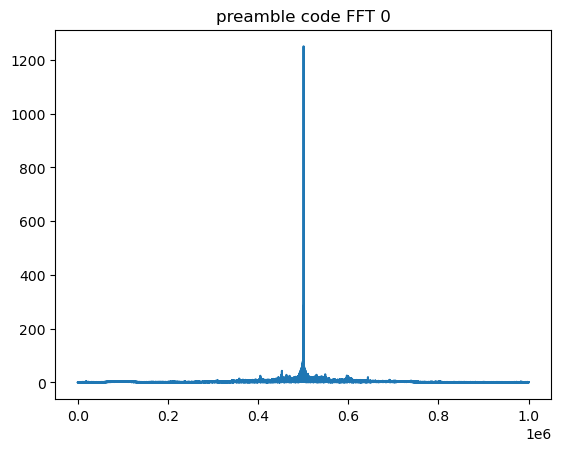

code Before optimized:freq1/ estbw * 2 ** Config.sf=array(7.97536324) code after optimized:freq/ estbw * 2 ** Config.sf=array(7.9784993)


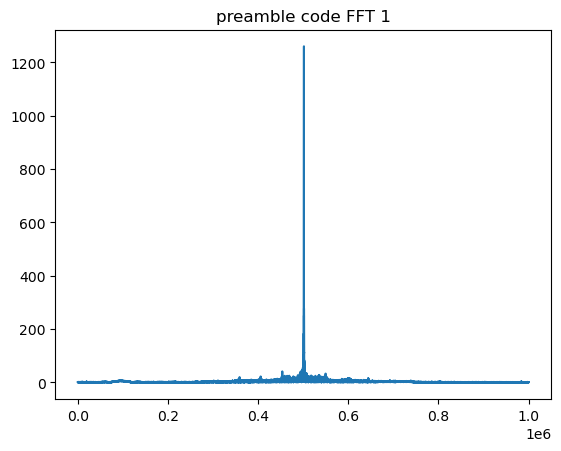

code Before optimized:freq1/ estbw * 2 ** Config.sf=array(15.98097439) code after optimized:freq/ estbw * 2 ** Config.sf=array(15.98321935)


In [ ]:
codes = xp.zeros((2, ), dtype=xp.float32)
betai = Config.bw / ((2 ** Config.sf) / Config.bw) * xp.pi # frequency slope to phase 2d slope, *pi
for pidx in range(Config.preamble_len, Config.preamble_len + 2):

    # FFT find frequency
    x1 = math.ceil(xp.polyval(coeff_time, pidx) * Config.fs)
    x2 = math.ceil(xp.polyval(coeff_time, pidx + 1) * Config.fs)
    nsymbr = xp.arange(x1, x2)
    sig = reader.get(x1, x2 - x1)
    tsymbr = nsymbr / Config.fs

    # base downchirp from est coeff coeft, not same as sig because we do not know code
    estcoef_this = xp.polyval(estcoef, pidx)
    beta1 = betai * (1 + 2 * estcoef_this / Config.sig_freq)
    estbw = Config.bw * (1 + estcoef_this / Config.sig_freq)
    beta2 = 2 * xp.pi * (estcoef_this - estbw / 2) - xp.polyval(coeff_time, pidx) * 2 * beta1 # 2ax+b=differential b=differential - 2 * beta1 * time
    coef2d_est = xp.array([to_scalar(beta1), to_scalar(beta2), 0])
    refchirp = xp.exp(-1j * xp.polyval(coef2d_est, tsymbr))

        

    sig2 = sig * refchirp
    data0 = myfft(sig2, n=Config.fft_n, plan=Config.plan)
    freq1 = xp.fft.fftshift(xp.fft.fftfreq(Config.fft_n, d=1 / Config.fs))[xp.argmax(xp.abs(data0))]
    freq, valnew = optimize_1dfreq(sig2, tsymbr, freq1, Config.fs / Config.fft_n * 5)  # valnew may be as low as 0.3, only half the power will be collected
    assert valnew > 0.9, f"FFT power <= 0.9, {pidx=} fft {freq=} {freq1=} FFTmaxpow={xp.max(xp.abs(data0))} {valnew=}"
    plt.plot(xp.abs(data0).get())
    plt.title(f"preamble code FFT {pidx-Config.preamble_len}")
    plt.show()
    # freq, valnew = optimize_1dfreq(sig2, tsymbr, freq)
    codei = freq / estbw * 2 ** Config.sf
    print(f"code Before optimized:{freq1/ estbw * 2 ** Config.sf=} code after optimized:{freq/ estbw * 2 ** Config.sf=}")
    assert codei >=0 and codei < 4096
    # print(f"{pidx=} optimized fft {freq=} maxpow={valnew} {code=:.12f}")
    code = around(codei)
    codes[pidx - Config.preamble_len] = code


### Construct curves for the 2 codes, still using only coeff_time and estcoef

In [ ]:


betai = Config.bw / ((2 ** Config.sf) / Config.bw) * xp.pi # frequency slope to phase 2d slope, *pi
for pidx in range(Config.preamble_len, Config.preamble_len + 2):
    code = codes[pidx - Config.preamble_len]
    estcoef_this = xp.polyval(estcoef, pidx)

    beta1 = betai * (1 + 2 * estcoef_this / Config.sig_freq) # beta1 = bw * pi
    beta2 = (2 * xp.pi * (xp.polyval(estcoef, pidx) + estbw * (code / 2 ** Config.sf - 0.5))
             - xp.polyval(coeff_time, pidx) * 2 * beta1)
    coef2d_est2 = xp.array([to_scalar(beta1), to_scalar(beta2), 0])
    coef2d_est2_2d = xp.polyval(coef2d_est2, xp.polyval(coeff_time, pidx)) - xp.polyval(coeffitlist[1, pidx - 1], xp.polyval(coeff_time, pidx))
    coef2d_est2[2] -= coef2d_est2_2d
    coeffitlist[pidx, 0] = coef2d_est2 # continuing the last phase in coeffitlist

    beta22 = 2 * xp.pi * (estcoef_this - estbw / 2) - xp.polyval(coeff_time, pidx) * 2 * beta1 # 2ax+b=differential b=differential - 2 * beta1 * time

    x1 = math.ceil(xp.polyval(coeff_time, pidx) * Config.fs)
    x2 = math.ceil(xp.polyval(coeff_time, pidx + 1) * Config.fs)
    x3 = math.ceil(xp.polyval(coeff_time, pidx + (1 - code / 2 ** Config.sf)) * Config.fs)
    nsymbr1 = xp.arange(x1, x3)
    tsymbr1 = nsymbr1 / Config.fs
    sig21 = reader.get(x1, x3 - x1)
    res2 = sig21.dot(xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr1)) )

    codephase.append(xp.angle(res2).item())
    powers.append(xp.abs(res2).item() / xp.sum(xp.abs(sig21)).item())
    # pltfig1(tsymbr1, xp.angle(sig21 * xp.exp(-1j * 2 * xp.pi * freq1 * tsymbr1)), title=f"residue {pidx=}").show()
    print(f"{pidx=} {code=} {xp.angle(res2)=} pow={xp.abs(res2)/xp.sum(xp.abs(sig21))}")
    fig=pltfig1(tsymbr, xp.angle(sig * xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))), title=f"residue {pidx=}", fig=fig)

    pltfig((
        (tsymbr, xp.unwrap(xp.angle(sig))), 
        (tsymbr, xp.polyval(coef2d_est, tsymbr) - xp.polyval(coef2d_est, tsymbr[0]) + xp.angle(sig[0]))), title=f"preamble code {pidx=} fit curve coef2d_est").show()
    pltfig1(tsymbr, xp.unwrap(xp.angle(sig)) - (xp.polyval(coef2d_est, tsymbr) - xp.polyval(coef2d_est, tsymbr[0]) + xp.angle(sig[0])), title=f"preamble code {pidx=} fit curve coef2d_est difference").show()
    pltfig((
        (tsymbr, xp.unwrap(xp.angle(sig))), 
        (tsymbr, xp.polyval(coef2d_est2, tsymbr) - xp.polyval(coef2d_est2, tsymbr[0]) + xp.angle(sig[0]))), title=f"preamble code {pidx=} fit curve coef2d_est2").show()
    pltfig1(tsymbr, xp.unwrap(xp.angle(sig)) - (xp.polyval(coef2d_est2, tsymbr) - xp.polyval(coef2d_est2, tsymbr[0]) + xp.angle(sig[0])), title=f"preamble code {pidx=} fit curve coef2d_est2 difference").show()



  


An error occurred: read length must be non-negative or -1


IndexError: Index 239 is out of bounds for axis 0 with size 2

In [ ]:

for pidx in range(Config.preamble_len + 2, Config.preamble_len + 4):
    x1 = math.ceil(xp.polyval(coeff_time, pidx) * Config.fs)
    x2 = math.ceil(xp.polyval(coeff_time, pidx + 1) * Config.fs)
    sig = reader.get(x1, x2 - x1)
    nsymbr = xp.arange(x1, x2)
    tsymbr = nsymbr / Config.fs

    estcoef_this = xp.polyval(estcoef, pidx)
    beta1 = - betai * (1 + 2 * estcoef_this / Config.sig_freq)
    estbw = Config.bw * (1 + estcoef_this / Config.sig_freq)
    # print(f"EEE! {Config.bw * (estcoef_this / Config.sig_freq)=}")
    beta2 = 2 * xp.pi * (xp.polyval(estcoef, pidx) + estbw / 2) - xp.polyval(coeff_time, pidx) * 2 * beta1 # 2ax+b=differential b=differential - 2 * beta1 * time
    coef2d_est2 = xp.array([to_scalar(beta1), to_scalar(beta2), 0])
    coef2d_est2_2d = xp.polyval(coef2d_est2, xp.polyval(coeff_time, pidx)) - xp.polyval(
        coeffitlist[pidx - 1], xp.polyval(coeff_time, pidx))
    coef2d_est2[2] -= coef2d_est2_2d
    coeffitlist[pidx] = coef2d_est2
    res2 = sig.dot(xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr)))
    fig = pltfig1(tsymbr, xp.angle(sig * xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))), title=f"residue {pidx=}", fig=fig)
    codephase.append(xp.angle(res2).item())
    powers.append(xp.abs(res2).item() / xp.sum(xp.abs(sig)).item())
    # pltfig1(None, xp.angle(sig * xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))), title=f"residue {pidx=}").show()
    # freq, power = optimize_1dfreq(sig * xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr)), tsymbr, 0)
    # print(f"EEE! {freq=} {power=}")

for pidx in range(Config.preamble_len + 4, Config.preamble_len + 5):
    x1 = math.ceil(xp.polyval(coeff_time, pidx) * Config.fs)
    x2 = math.ceil(xp.polyval(coeff_time, pidx + 0.25) * Config.fs)
    nsymbr = xp.arange(x1, x2)
    tsymbr = nsymbr / Config.fs
    sig = reader.get(x1, x2 - x1)

    estcoef_this = xp.polyval(estcoef, pidx)
    beta1 = - betai * (1 + 2 * estcoef_this / Config.sig_freq)
    estbw = Config.bw * (1 + estcoef_this / Config.sig_freq)
    beta2 = 2 * xp.pi * (xp.polyval(estcoef, pidx) + estbw / 2) - xp.polyval(coeff_time, pidx) * 2 * beta1 # 2ax+b=differential b=differential - 2 * beta1 * time
    coef2d_est2 = xp.array([to_scalar(beta1), to_scalar(beta2), 0])
    coef2d_est2_2d = xp.polyval(coef2d_est2, xp.polyval(coeff_time, pidx)) - xp.polyval(
        coeffitlist[pidx - 1], xp.polyval(coeff_time, pidx))
    coef2d_est2[2] -= coef2d_est2_2d
    cd2 = xp.angle(sig.dot(xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr)) ))#!!!!!!!!!!!! TODO here we align phase for the last symbol
    print(f"WARN last phase {cd2=} manually add phase compensation")
    # coef2d_est2[2] += cd2
    # cd2 = xp.angle(sig.dot(xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr)) ))#!!!!!!!!!!!! TODO here we align phase for the last symbol
    # assert abs(cd2) < 1e-4
    coeffitlist[pidx] = coef2d_est2
    res2 = sig.dot(xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr)))
    codephase.append(xp.angle(res2).item())
    powers.append(xp.abs(res2).item() / xp.sum(xp.abs(sig)).item())
    fig=pltfig1(tsymbr, xp.angle(sig * xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr))), title=f"residue {pidx=}", fig=fig)


WARN last phase cd2=array(2.79661844) manually add phase compensation


In [ ]:

startphase = xp.polyval(coeffitlist[Config.preamble_len + 4], xp.polyval(coeff_time, Config.preamble_len + 5 - 0.75))

coef2d_ests = []
ifreqs = []
# for pidx in range(Config.preamble_len + 5, Config.preamble_len + 5 + Config.payload_len):
codephase2 = [] # !!! todo !!!
powers = []
codes = []
codexdiffs = []
for pidx in range(Config.preamble_len + 5, Config.total_len):
    tstart = xp.polyval(coeff_time, pidx - 0.75)
    tend = xp.polyval(coeff_time, pidx + 1 - 0.75)
    x1 = math.ceil(tstart * Config.fs)
    x2 = math.ceil(tend * Config.fs)
    nsymbr = xp.arange(x1, x2)
    sig = reader.get(x1, x2 - x1)
    if xp.mean(xp.abs(sig)) < 0.01:
        print(f"{pidx=} {xp.mean(xp.abs(sig))=} too small. is symbol ending? quitting, payload_len={pidx - Config.preamble_len - 5}")
        break
    
    x1 = math.ceil(tstart * Config.fs)
    x2 = math.ceil(tend * Config.fs)
    nsymbr = xp.arange(x1, x2)
    tsymbr = nsymbr / Config.fs

    # pltfig1(tsymbr, xp.unwrap(xp.angle(reader.get(x1, x2-x1))), title=f"{pidx=}").show()
    # pltfig1(tsymbr, xp.abs(reader.get(x1, x2-x1)), title=f"{pidx=}").show()
    assert xp.mean(xp.abs(reader.get(x1, x2-x1))) > 0.1, f"{pidx=} {xp.mean(xp.abs(reader.get(x1, x2-x1)))=} too small. is symbol ending?"
    estcoef_this = xp.polyval(coeff, pidx)

    beta1 = Config.bw / ((2 ** Config.sf) / Config.bw) * xp.pi * (1 + 2 * estcoef_this / Config.sig_freq)
    estbw = Config.bw * (1 + estcoef_this / Config.sig_freq)
    beta2 = 2 * xp.pi * (xp.polyval(coeff, pidx) - estbw / 2) - tstart * 2 * beta1  # 2ax+b=differential b=differential - 2 * beta1 * time
    coef2d_est = xp.array([to_scalar(beta1), to_scalar(beta2), 0])

    sig2 = reader.get(x1, x2-x1) * xp.exp(-1j * xp.polyval(coef2d_est, tsymbr))
    data0 = myfft(sig2, n=Config.fft_n, plan=Config.plan)
    freq1 = xp.fft.fftshift(xp.fft.fftfreq(Config.fft_n, d=1 / Config.fs))[xp.argmax(xp.abs(data0))]
    freq, valnew = optimize_1dfreq_fast(sig2, tsymbr, freq1, Config.fs / Config.fft_n * 5) # valnew may be as low as 0.3, only half the power will be collected
    # freq = freq1 # todo !!!
    # assert valnew > 0.3, f"{freq=} {freq1=} {valnew=}"
    if freq < 0: freq += estbw
    codex = freq / estbw * 2 ** Config.sf
    code = around(codex)
    # print(f"{codex=} {code=}")

    tmid = tstart * (code / 2 ** Config.sf) + tend * (1 - code / 2 ** Config.sf)
    tmid = tmid.item()
    x3 = math.ceil(tmid * Config.fs)

    nsymbr1 = xp.arange(x1, x3)
    tsymbr1 = nsymbr1 / Config.fs
    nsymbr2 = xp.arange(x3, x2)
    tsymbr2 = nsymbr2 / Config.fs

    beta2 = (2 * xp.pi * (xp.polyval(coeff, pidx) + estbw * (code / 2 ** Config.sf - 0.5))
             - tstart * 2 * beta1)
    coef2d_est2 = xp.array([to_scalar(beta1), to_scalar(beta2), 0])
    coef2d_est2_2d = xp.polyval(coef2d_est2, tstart) - startphase
    coef2d_est2[2] -= coef2d_est2_2d

    beta2a = (2 * xp.pi * (xp.polyval(coeff, pidx) + estbw * (code / 2 ** Config.sf - 1.5))
              - tstart * 2 * beta1)
    coef2d_est2a = xp.array([to_scalar(beta1), to_scalar(beta2a), 0])
    coef2d_est2a_2d = xp.polyval(coef2d_est2a, tmid) - xp.polyval(coef2d_est2, tmid)
    coef2d_est2a[2] -= coef2d_est2a_2d

    res2 = reader.get(x1, x3-x1).dot(xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr1))) / xp.sum(xp.abs(reader.get(x1, x3-x1)))
    res2a = reader.get(x3, x2-x3).dot(xp.exp(-1j * xp.polyval(coef2d_est2a, tsymbr2))) / xp.sum(xp.abs(reader.get(x3, x2-x3)))

    if not (xp.abs(res2).item() > 0.7 or code > 2 ** Config.sf * 0.7) or not (xp.abs(res2a).item() > 0.7 or code < 2 ** Config.sf * 0.2):
        pltfig1(tsymbr1, xp.angle(reader.get(x1, x3-x1) * xp.exp(-1j * xp.polyval(coef2d_est2, tsymbr1))), title=f"{pidx=} 1st angle {codex=} pow={xp.abs(res2).item()}").show()
        pltfig1(tsymbr2, xp.angle(reader.get(x3, x2-x3) * xp.exp(-1j * xp.polyval(coef2d_est2a, tsymbr2))), title=f"{pidx=} 2st angle {codex=} pow={xp.abs(res2a).item()}").show()

    assert xp.abs(res2).item() > 0.7 or code > 2 ** Config.sf * 0.7, f"{pidx=} {code=} 1st power {xp.abs(res2).item()}<0.7"
    assert xp.abs(res2a).item() > 0.7 or code < 2 ** Config.sf * 0.2, f"{pidx=} {code=} 2nd power {xp.abs(res2a).item()}<0.7"

    endphase = xp.polyval(coef2d_est2a, tend)
    ifreq1 = 2 * xp.pi * (xp.polyval(coeff, pidx) + estbw * (code / 2 ** Config.sf - 0.5))
    ifreq2 = 2 * xp.pi * (xp.polyval(coeff, pidx) + estbw * (code / 2 ** Config.sf - 1.5))

    startphase = endphase
    powers.append(xp.abs(res2).item())
    powers.append(xp.abs(res2a).item())
    codephase2.append(xp.angle(res2).item())
    codephase2.append(xp.angle(res2a).item())
    codephase.append(xp.angle(res2).item())
    codephase.append(xp.angle(res2a).item())
    coef2d_ests.append(coef2d_est2)
    coef2d_ests.append(coef2d_est2a)
    codes.append(code)
    codexdiffs.append(abs(codex - code))
pltfig1(None, xp.unwrap(codexdiffs), title="codexdiffs").show()

In [ ]:

anslist = []
anslista = []
anslistb = []
anslist2 = []
anslist2a = []
anslist2b = []
for pidx in range(2, len(codephase2), 2):
    code = codes[pidx // 2]
    tmid = tstart * (code / 2 ** Config.sf) + tend * (1 - code / 2 ** Config.sf)
    tmid = tmid.item()
    ifreq1 = xp.polyval(sqlist([2 * coef2d_ests[pidx][0], coef2d_ests[pidx][1]]), tstart ) - xp.polyval(sqlist([2 * coef2d_ests[pidx - 1][0], coef2d_ests[pidx - 1][1]]), tstart )
    ifreq2 = xp.polyval(sqlist([2 * coef2d_ests[pidx + 1][0], coef2d_ests[pidx + 1][1]]), tmid ) - xp.polyval(sqlist([2 * coef2d_ests[pidx][0], coef2d_ests[pidx][1]]), tmid )
    # print(pidx, ifreq1, ifreq2)
    a1 = (wrap(codephase2[pidx] - codephase2[pidx - 1] - xp.pi) + xp.pi) / 2 / xp.pi / ifreq1
    if ifreq1 < 0: a1 = (wrap(codephase2[pidx] - codephase2[pidx - 1] + xp.pi) - xp.pi) / 2 / xp.pi / ifreq1
    assert a1>=0
    a1a = a1 + 1 / abs(ifreq1)
    a1b = a1 - 1 / abs(ifreq1)
    anslist.append(to_scalar((a1)))
    anslista.append(to_scalar((a1a)))
    anslistb.append(to_scalar((a1b)))
    a2 = wrap(codephase2[pidx + 1] - codephase2[pidx]) / 2 / xp.pi / ifreq2
    a2a = a2 + 1 / abs(ifreq2)
    a2b = a2 - 1 / abs(ifreq2)
    anslist2.append(to_scalar((a2)))
    anslist2a.append(to_scalar((a2a)))
    anslist2b.append(to_scalar((a2b)))

anslist = xp.unwrap(sqlist(anslist))
tdifflist = anslist
print(type(tdifflist))
fig = pltfig1(None, tdifflist)
fig = pltfig1(None, anslista, title="tdifflist", fig=fig)
pltfig1(None, anslistb, title="tdifflista", fig=fig).show()
anslist2 = xp.unwrap(sqlist(anslist2))
tdifflist2 = anslist2
fig = pltfig1(None, tdifflist2, title="tdifflist")
fig = pltfig1(None, anslist2a, title="tdifflist", fig=fig)
pltfig1(None, anslist2b, title="tdifflista", fig=fig).show()


pltfig1(None, powers, title="powers").show()
pltfig1(None, xp.unwrap(codephase), title="unwrap phase").show()




<class 'cupy.ndarray'>
